<h1>Elecciones 2023</h1>

<h2>Configuracion</h2>

<b>Instalations</b>

In [1]:
%pip install --upgrade plotly
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install matplotlib
%pip install scipy
%pip install geopandas


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\OneDrive\Documents\Marcos\Programacion\PYTHON\elecciones\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\OneDrive\Documents\Marcos\Programacion\PYTHON\elecciones\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\OneDrive\Documents\Marcos\Programacion\PYTHON\elecciones\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\OneDrive\Documents\Marcos\Programacion\PYTHON\elecciones\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\OneDrive\Documents\Marcos\Programacion\PYTHON\elecciones\venv\Scripts\python.exe -m pip install --upgrade pip' command.


<b>Imports</b>

In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
import geopandas as gpd

<b>Pandas Config</b>

In [3]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

<h2>Base de datos general</h2>

<b>Importar archivo</b>

In [4]:
# Fuente: https://www.argentina.gob.ar/dine/resultados-electorales/elecciones-2023
file_name = "ResultadosElectorales_2023.csv"
df_data = pd.read_csv(file_name, low_memory=False, encoding="utf-8")
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5868102 entries, 0 to 5868101
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   año                       int64  
 1   eleccion_tipo             object 
 2   recuento_tipo             object 
 3   padron_tipo               object 
 4   distrito_id               int64  
 5   distrito_nombre           object 
 6   seccionprovincial_id      int64  
 7   seccionprovincial_nombre  object 
 8   seccion_id                int64  
 9   seccion_nombre            object 
 10  circuito_id               object 
 11  circuito_nombre           object 
 12  mesa_id                   int64  
 13  mesa_tipo                 object 
 14  mesa_electores            int64  
 15  cargo_id                  int64  
 16  cargo_nombre              object 
 17  agrupacion_id             int64  
 18  agrupacion_nombre         object 
 19  lista_numero              float64
 20  lista_nombre            

<b>Listar los cargos</b>

In [5]:
df_data["cargo_nombre"].unique()

array(['PRESIDENTE Y VICE', 'SENADOR NACIONAL', 'JEFE/A DE GOBIERNO',
       'DIPUTADO NACIONAL', 'DIPUTADO PROVINCIAL', 'SENADOR PROVINCIAL',
       'GOBERNADOR Y VICE', 'INTENDENTE', 'PARLAMENTO MERCOSUR NACIONAL',
       'PARLAMENTO MERCOSUR REGIONAL', 'CONCEJAL',
       'MIEMBROS DE JUNTA COMUNAL', 'DIPUTADOS/AS DE LA CIUDAD AUTONOMA'],
      dtype=object)

<b>Preparar la informacion</b>

In [6]:
cargo_presidencial = "PRESIDENTE Y VICE"

# Agregar un ID combinado para asegurarase que sea unico
df_data['id_mesa_unico'] = df_data['distrito_id'].astype(str) + "-" + \
                          df_data['seccionprovincial_id'].astype(str) + "-" + \
                          df_data['seccion_id'].astype(str) + "-" + \
                          df_data['circuito_id'].astype(str) + "-" + \
                          df_data['mesa_id'].astype(str)

# Considerar solo los votos positivos
votos_positivos = df_data[df_data['votos_tipo'] == "POSITIVO"]

# Considerar solo los votos para presidente
votos_positivos_presidenciales = votos_positivos[votos_positivos["cargo_nombre"]==cargo_presidencial]

# Obtener los totales por mesa
votos_positivos_presidenciales_by_mesa = votos_positivos_presidenciales.groupby('id_mesa_unico')['votos_cantidad'].sum().reset_index()

#Agregar el total de cada mesa a cada registro
votos_positivos_presidenciales = votos_positivos_presidenciales.merge(votos_positivos_presidenciales_by_mesa, on='id_mesa_unico', how='left', suffixes=('', '_sum'))
# Renombrar la columna
votos_positivos_presidenciales = votos_positivos_presidenciales.rename(columns={'votos_cantidad_sum': 'total_votos_mesa'})

# Calcular el porcentaje
votos_positivos_presidenciales['votos_porcentaje'] = (votos_positivos_presidenciales['votos_cantidad'] / votos_positivos_presidenciales['total_votos_mesa']) * 100

# Eliminar las mesas que dan NaN en el porcentaje (tienen 0 votos)
votos_positivos_presidenciales.dropna(subset=['votos_porcentaje'], inplace=True)


<h2>Chequear TOTALES por partido con la informacion oficial</h2><br>
Para asegurarse que estamos trabjando con el 100% de la informacion

In [7]:
# Calcular totales
totales_por_partido = votos_positivos_presidenciales.groupby('agrupacion_nombre')['votos_cantidad'].sum()

# Convertir a DataFrame
df_totales = totales_por_partido.reset_index()

# Calcular el total general
overall_total = df_totales['votos_cantidad'].sum()
print(f"Total General: {overall_total:,}")

# Calcular el porcentaje por partido
df_totales['porcentaje'] = (df_totales['votos_cantidad'] / overall_total) * 100
# Agregar separadores a la cantidad de votos
df_totales['votos_cantidad'] = df_totales['votos_cantidad'].apply(lambda x: f"{x:,}")

# Display the DataFrame
df_totales

Total General: 26,291,718


,agrupacion_nombre,votos_cantidad,porcentaje
0,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,"709,932",2.70
1,HACEMOS POR NUESTRO PAIS,"1,784,315",6.79
2,JUNTOS POR EL CAMBIO,"6,267,152",23.84
3,LA LIBERTAD AVANZA,"7,884,336",29.99
4,UNION POR LA PATRIA,"9,645,983",36.69


<img src="totales_oficiales_2023.png">

<h2>Informacion por partido</h2>

<b>Totales</b><br>
Ponderado en base a la cantidad de votantes por mesa

In [8]:
up_total = votos_positivos_presidenciales[(votos_positivos_presidenciales['agrupacion_nombre'] == "UNION POR LA PATRIA")].copy()
lla_total = votos_positivos_presidenciales[(votos_positivos_presidenciales['agrupacion_nombre'] == "LA LIBERTAD AVANZA")].copy()
jxc_total = votos_positivos_presidenciales[(votos_positivos_presidenciales['agrupacion_nombre'] == "JUNTOS POR EL CAMBIO")].copy()

# Promedio de votantes por mesa (es lo mismo para todos los partidos) 
promedio_vot = jxc_total["total_votos_mesa"].mean()

# Agregar la ponderacion a la tabla de cada partido
up_total['ponderacion'] = up_total['total_votos_mesa'] / promedio_vot
lla_total['ponderacion'] = lla_total['total_votos_mesa'] / promedio_vot
jxc_total['ponderacion'] = jxc_total['total_votos_mesa'] / promedio_vot



In [70]:
# Definicion de la funcion Gaussiana
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(- (x - mean) ** 2 / (2 * standard_deviation ** 2))

UP Mesas por Rangos
Del 0.00 al 2.00: 105
Del 2.00 al 4.00: 68
Del 4.00 al 6.00: 295
Del 6.00 al 8.00: 831
Del 8.00 al 10.00: 1476
Del 10.00 al 12.00: 1958
Del 12.00 al 14.00: 2119
Del 14.00 al 16.00: 2133
Del 16.00 al 18.00: 2237
Del 18.00 al 20.00: 2628
Del 20.00 al 22.00: 3122
Del 22.00 al 24.00: 3502
Del 24.00 al 26.00: 4083
Del 26.00 al 28.00: 4588
Del 28.00 al 30.00: 5030
Del 30.00 al 32.00: 5612
Del 32.00 al 34.00: 6048
Del 34.00 al 36.00: 5880
Del 36.00 al 38.00: 5878
Del 38.00 al 40.00: 5461
Del 40.00 al 42.00: 5185
Del 42.00 al 44.00: 4547
Del 44.00 al 46.00: 4076
Del 46.00 al 48.00: 3584
Del 48.00 al 50.00: 3236
Del 50.00 al 52.00: 3286
Del 52.00 al 54.00: 2781
Del 54.00 al 56.00: 2508
Del 56.00 al 58.00: 2295
Del 58.00 al 60.00: 1853
Del 60.00 al 62.00: 1482
Del 62.00 al 64.00: 1189
Del 64.00 al 66.00: 938
Del 66.00 al 68.00: 637
Del 68.00 al 70.00: 473
Del 70.00 al 72.00: 351
Del 72.00 al 74.00: 275
Del 74.00 al 76.00: 211
Del 76.00 al 78.00: 181
Del 78.00 al 80.00: 166
De

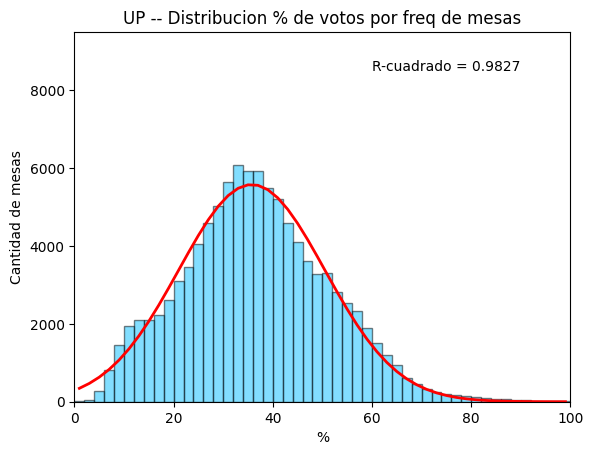

In [80]:
## UP
# Histograma
up_hist, up_bin_edges = np.histogram(up_total['votos_porcentaje'], bins=50, weights=up_total['ponderacion'])
up_bin_centers = 0.5 * (up_bin_edges[1:] + up_bin_edges[:-1])

# Cantidad de mesas por rango de porcentajes
up_mesas_total, up_bin_edges_total = np.histogram(up_total['votos_porcentaje'], bins=50, range=(0, 100))
print(f"UP Mesas por Rangos")
for i in range(len(up_mesas_total)):
    print(f"Del {up_bin_edges_total[i]:.2f} al {up_bin_edges_total[i+1]:.2f}: {up_mesas_total[i]}")

# Ajustar la funcion Gaussiana a la data del histograma
up_popt, _ = curve_fit(gaussian, up_bin_centers, up_hist, p0=[np.mean(up_total['votos_porcentaje']), max(up_hist), np.std(up_total['votos_porcentaje'])])

# Obtener el R-squared
up_predicted = gaussian(up_bin_centers, *up_popt)
up_SST = np.sum((up_hist - np.mean(up_hist))**2)
up_SSR = np.sum((up_hist - up_predicted)**2)
up_R_squared = 1 - (up_SSR / up_SST)


# Graficar el histograma
plt.hist(up_total['votos_porcentaje'], bins=50, weights=up_total['ponderacion'], edgecolor='black', color="#06beff", alpha=0.5)

# Graficar la curva gaussiana
plt.plot(up_bin_centers, gaussian(up_bin_centers, *up_popt), color='red', lw=2)

# Add title and labels
plt.title('UP -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 9500)
plt.xlim(0, 100)

# Mostrar el R-squared en el grafico
plt.text(60, 8500, 'R-cuadrado = {:.4f}'.format(up_R_squared))

# Log de las mediciones
print(f"Parámetros Estadísticos para la curva de UP:\n"
      f"Promedio: {up_popt[0]:,.2f}\n"
      f"Amplitud: {up_popt[1]:,.2f}\n"
      f"Desviación Estándar: {up_popt[2]:,.2f}\n"
      f"Sesgo: {up_total['votos_porcentaje'].skew():,.2f}\n"
      f"R-cuadrado: {up_R_squared:.2f}\n")     

# Exportar imagen
plt.savefig('up-total.png')

# Mostrar grafico
plt.show()



LLA Mesas por Rangos
Del 0.00 al 2.00: 172
Del 2.00 al 4.00: 86
Del 4.00 al 6.00: 99
Del 6.00 al 8.00: 167
Del 8.00 al 10.00: 222
Del 10.00 al 12.00: 377
Del 12.00 al 14.00: 877
Del 14.00 al 16.00: 1849
Del 16.00 al 18.00: 3420
Del 18.00 al 20.00: 5070
Del 20.00 al 22.00: 7036
Del 22.00 al 24.00: 8205
Del 24.00 al 26.00: 8958
Del 26.00 al 28.00: 8987
Del 28.00 al 30.00: 8722
Del 30.00 al 32.00: 8370
Del 32.00 al 34.00: 7893
Del 34.00 al 36.00: 6966
Del 36.00 al 38.00: 6057
Del 38.00 al 40.00: 4943
Del 40.00 al 42.00: 4155
Del 42.00 al 44.00: 3190
Del 44.00 al 46.00: 2395
Del 46.00 al 48.00: 1727
Del 48.00 al 50.00: 1088
Del 50.00 al 52.00: 808
Del 52.00 al 54.00: 454
Del 54.00 al 56.00: 283
Del 56.00 al 58.00: 146
Del 58.00 al 60.00: 85
Del 60.00 al 62.00: 40
Del 62.00 al 64.00: 38
Del 64.00 al 66.00: 11
Del 66.00 al 68.00: 19
Del 68.00 al 70.00: 14
Del 70.00 al 72.00: 10
Del 72.00 al 74.00: 1
Del 74.00 al 76.00: 3
Del 76.00 al 78.00: 0
Del 78.00 al 80.00: 1
Del 80.00 al 82.00: 2
Del 8

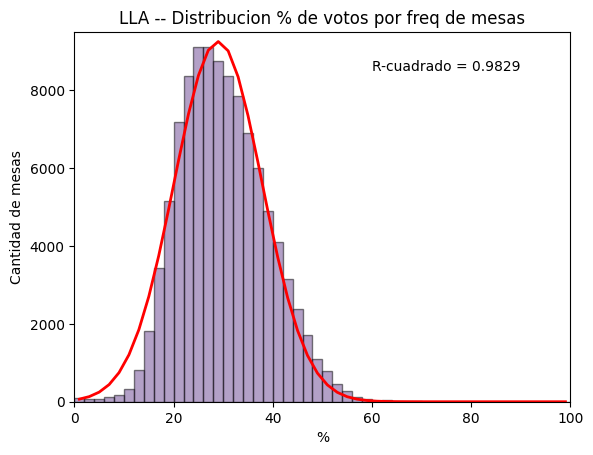

In [79]:
## LLA
# Histograma
lla_hist, lla_bin_edges = np.histogram(lla_total['votos_porcentaje'], bins=50, weights=lla_total['ponderacion'])
lla_bin_centers = 0.5 * (lla_bin_edges[1:] + lla_bin_edges[:-1])

# Cantidad de mesas por rango de porcentajes
lla_mesas_total, lla_bin_edges_total = np.histogram(lla_total['votos_porcentaje'], bins=50, range=(0, 100))
print(f"LLA Mesas por Rangos")
for i in range(len(lla_mesas_total)):
    print(f"Del {lla_bin_edges_total[i]:.2f} al {lla_bin_edges_total[i+1]:.2f}: {lla_mesas_total[i]}")

# Ajustar la funcion Gaussiana a la data del histograma
lla_popt, _ = curve_fit(gaussian, lla_bin_centers, lla_hist, p0=[np.mean(lla_total['votos_porcentaje']), max(lla_hist), np.std(lla_total['votos_porcentaje'])])

# Obtener el R-squared
lla_predicted = gaussian(lla_bin_centers, *lla_popt)
lla_SST = np.sum((lla_hist - np.mean(lla_hist))**2)
lla_SSR = np.sum((lla_hist - lla_predicted)**2)
lla_R_squared = 1 - (lla_SSR / lla_SST)


# Graficar el histograma
plt.hist(lla_total['votos_porcentaje'], bins=50, weights=lla_total['ponderacion'], edgecolor='black', color="#694291", alpha=0.5)

# Graficar la curva gaussiana
plt.plot(lla_bin_centers, gaussian(lla_bin_centers, *lla_popt), color='red', lw=2)

# Add title and labels
plt.title('LLA -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 9500)
plt.xlim(0, 100)

# Mostrar el R-squared en el grafico
plt.text(60, 8500, 'R-cuadrado = {:.4f}'.format(lla_R_squared))

# Log de las mediciones
print(f"Parámetros Estadísticos para la curva de LLA:\n"
      f"Promedio: {lla_popt[0]:,.2f}\n"
      f"Amplitud: {lla_popt[1]:,.2f}\n"
      f"Desviación Estándar: {lla_popt[2]:,.2f}\n"
      f"Sesgo: {lla_total['votos_porcentaje'].skew():,.2f}\n"
      f"R-cuadrado: {lla_R_squared:.2f}\n")     

# Exportar imagen
plt.savefig('lla-total.png')

# Mostrar grafico
plt.show()

JxC Mesas por Rangos
Del 0.00 al 2.00: 399
Del 2.00 al 4.00: 803
Del 4.00 al 6.00: 1516
Del 6.00 al 8.00: 2798
Del 8.00 al 10.00: 4237
Del 10.00 al 12.00: 5566
Del 12.00 al 14.00: 6205
Del 14.00 al 16.00: 6736
Del 16.00 al 18.00: 7110
Del 18.00 al 20.00: 6923
Del 20.00 al 22.00: 7257
Del 22.00 al 24.00: 6941
Del 24.00 al 26.00: 6642
Del 26.00 al 28.00: 6152
Del 28.00 al 30.00: 5490
Del 30.00 al 32.00: 5139
Del 32.00 al 34.00: 4439
Del 34.00 al 36.00: 3872
Del 36.00 al 38.00: 3243
Del 38.00 al 40.00: 2510
Del 40.00 al 42.00: 2080
Del 42.00 al 44.00: 1551
Del 44.00 al 46.00: 1175
Del 46.00 al 48.00: 934
Del 48.00 al 50.00: 711
Del 50.00 al 52.00: 612
Del 52.00 al 54.00: 424
Del 54.00 al 56.00: 357
Del 56.00 al 58.00: 259
Del 58.00 al 60.00: 191
Del 60.00 al 62.00: 192
Del 62.00 al 64.00: 143
Del 64.00 al 66.00: 105
Del 66.00 al 68.00: 79
Del 68.00 al 70.00: 68
Del 70.00 al 72.00: 46
Del 72.00 al 74.00: 16
Del 74.00 al 76.00: 8
Del 76.00 al 78.00: 5
Del 78.00 al 80.00: 4
Del 80.00 al 82.0

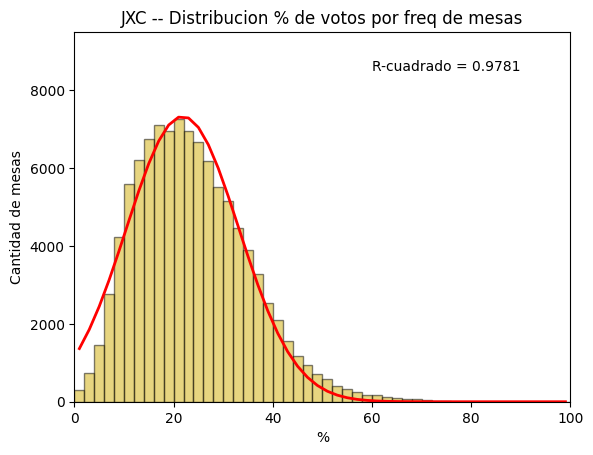

In [81]:
## JXC
# Histograma
jxc_hist, jxc_bin_edges = np.histogram(jxc_total['votos_porcentaje'], bins=50, weights=jxc_total['ponderacion'])
jxc_bin_centers = 0.5 * (jxc_bin_edges[1:] + jxc_bin_edges[:-1])

# Ajustar la funcion Gaussiana a la data del histograma
jxc_popt, _ = curve_fit(gaussian, jxc_bin_centers, jxc_hist, p0=[np.mean(jxc_total['votos_porcentaje']), max(jxc_hist), np.std(jxc_total['votos_porcentaje'])])

# Cantidad de mesas por rango de porcentajes
jxc_mesas_total, jxc_bin_edges_total = np.histogram(jxc_total['votos_porcentaje'], bins=50, range=(0, 100))
print(f"JxC Mesas por Rangos")
for i in range(len(jxc_mesas_total)):
    print(f"Del {jxc_bin_edges_total[i]:.2f} al {jxc_bin_edges_total[i+1]:.2f}: {jxc_mesas_total[i]}")

# Obtener el R-squared
jxc_predicted = gaussian(jxc_bin_centers, *jxc_popt)
jxc_SST = np.sum((jxc_hist - np.mean(jxc_hist))**2)
jxc_SSR = np.sum((jxc_hist - jxc_predicted)**2)
jxc_R_squared = 1 - (jxc_SSR / jxc_SST)


# Graficar el histograma
plt.hist(jxc_total['votos_porcentaje'], bins=50, weights=jxc_total['ponderacion'], edgecolor='black', color="#d1ac03", alpha=0.5)

# Graficar la curva gaussiana
plt.plot(jxc_bin_centers, gaussian(jxc_bin_centers, *jxc_popt), color='red', lw=2)

# Add title and labels
plt.title('JXC -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 9500)
plt.xlim(0, 100)

# Mostrar el R-squared en el grafico
plt.text(60, 8500, 'R-cuadrado = {:.4f}'.format(jxc_R_squared))

# Log de las mediciones
print(f"Parámetros Estadísticos para la curva de JXC:\n"
      f"Promedio: {jxc_popt[0]:,.2f}\n"
      f"Amplitud: {jxc_popt[1]:,.2f}\n"
      f"Desviación Estándar: {jxc_popt[2]:,.2f}\n"
      f"Sesgo: {jxc_total['votos_porcentaje'].skew():,.2f}\n"
      f"R-cuadrado: {jxc_R_squared:.2f}\n")     

# Exportar imagen
plt.savefig('jxc-total.png')

# Mostrar grafico
plt.show()

<b>Colas</b><br>
Filtrando mesas con 30 votos o mas, en las que los candidatos obtuvieron mas del 70%.

In [43]:
# Resultados filtrados 
up_cola = up_total[(up_total['votos_porcentaje'] > 70) & (up_total['total_votos_mesa'] > 30)]
lla_cola = lla_total[(lla_total['votos_porcentaje'] > 70) & (lla_total['total_votos_mesa'] > 30)]
jxc_cola = jxc_total[(jxc_total['votos_porcentaje'] > 70) & (jxc_total['total_votos_mesa'] > 30)]


UP obtuvo 70% o mas en 1,785 mesas, por un total de 322,699 votos.
Esto representa el 3.35% de sus votos y el 1.23% del total de votos.

UP Mesas por Rangos
Del 70.00 al 70.60: 111
Del 70.60 al 71.20: 106
Del 71.20 al 71.80: 89
Del 71.80 al 72.40: 94
Del 72.40 al 73.00: 84
Del 73.00 al 73.60: 74
Del 73.60 al 74.20: 66
Del 74.20 al 74.80: 69
Del 74.80 al 75.40: 61
Del 75.40 al 76.00: 59
Del 76.00 al 76.60: 55
Del 76.60 al 77.20: 51
Del 77.20 al 77.80: 57
Del 77.80 al 78.40: 42
Del 78.40 al 79.00: 52
Del 79.00 al 79.60: 57
Del 79.60 al 80.20: 47
Del 80.20 al 80.80: 49
Del 80.80 al 81.40: 42
Del 81.40 al 82.00: 34
Del 82.00 al 82.60: 34
Del 82.60 al 83.20: 43
Del 83.20 al 83.80: 28
Del 83.80 al 84.40: 23
Del 84.40 al 85.00: 35
Del 85.00 al 85.60: 16
Del 85.60 al 86.20: 22
Del 86.20 al 86.80: 20
Del 86.80 al 87.40: 27
Del 87.40 al 88.00: 16
Del 88.00 al 88.60: 24
Del 88.60 al 89.20: 14
Del 89.20 al 89.80: 18
Del 89.80 al 90.40: 14
Del 90.40 al 91.00: 18
Del 91.00 al 91.60: 14
Del 91.60 al 

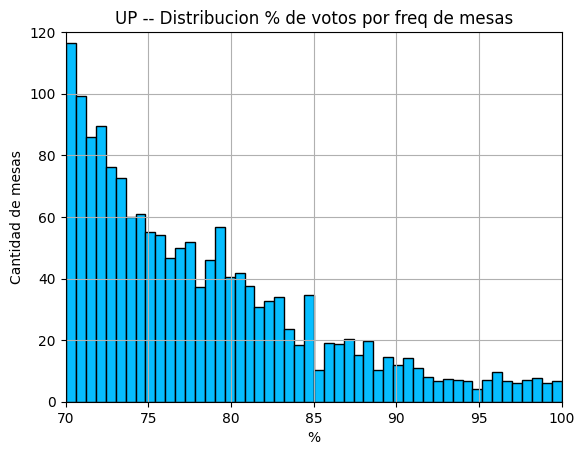

In [67]:
## UP

# Estadisticas
up_cola_mesas = len(up_cola)
up_cola_votos = up_cola["votos_cantidad"].sum()
up_cola_porc_sus_votos = (up_cola["votos_cantidad"].sum() / up_total["votos_cantidad"].sum()) * 100
up_cola_porc_total = (up_cola["votos_cantidad"].sum() / overall_total) * 100
print(f"UP obtuvo 70% o mas en {up_cola_mesas:,} mesas, por un total de {up_cola_votos:,} votos.")
print(f"Esto representa el {up_cola_porc_sus_votos:.2f}% de sus votos y el {up_cola_porc_total:.2f}% del total de votos.\n")
# Cantidad de mesas por rango de porcentajes
up_mesas, up_bin_edges = np.histogram(up_cola['votos_porcentaje'], bins=50, range=(70, 100))
print(f"UP Mesas por Rangos")
for i in range(len(up_mesas)):
    print(f"Del {up_bin_edges[i]:.2f} al {up_bin_edges[i+1]:.2f}: {up_mesas[i]}")


# Crear Histograma
up_cola['votos_porcentaje'].hist(bins=50, weights=up_cola['ponderacion'], edgecolor='black', color="#06beff")

# Add title and labels
plt.title('UP -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 120)
plt.xlim(70, 100)

# Exportar imagen
plt.savefig('up-cola.png')

# Mostrar grafico
plt.show()

LLA obtuvo 70% o mas en 14 mesas, por un total de 1,233 votos.
Esto representa el 0.02% de sus votos y el 0.00% del total de votos.

LLA Mesas por Rangos
Del 70.00 al 70.60: 4
Del 70.60 al 71.20: 1
Del 71.20 al 71.80: 3
Del 71.80 al 72.40: 0
Del 72.40 al 73.00: 1
Del 73.00 al 73.60: 0
Del 73.60 al 74.20: 0
Del 74.20 al 74.80: 1
Del 74.80 al 75.40: 1
Del 75.40 al 76.00: 1
Del 76.00 al 76.60: 0
Del 76.60 al 77.20: 0
Del 77.20 al 77.80: 0
Del 77.80 al 78.40: 0
Del 78.40 al 79.00: 1
Del 79.00 al 79.60: 0
Del 79.60 al 80.20: 0
Del 80.20 al 80.80: 0
Del 80.80 al 81.40: 0
Del 81.40 al 82.00: 0
Del 82.00 al 82.60: 0
Del 82.60 al 83.20: 0
Del 83.20 al 83.80: 0
Del 83.80 al 84.40: 0
Del 84.40 al 85.00: 0
Del 85.00 al 85.60: 0
Del 85.60 al 86.20: 0
Del 86.20 al 86.80: 0
Del 86.80 al 87.40: 0
Del 87.40 al 88.00: 1
Del 88.00 al 88.60: 0
Del 88.60 al 89.20: 0
Del 89.20 al 89.80: 0
Del 89.80 al 90.40: 0
Del 90.40 al 91.00: 0
Del 91.00 al 91.60: 0
Del 91.60 al 92.20: 0
Del 92.20 al 92.80: 0
Del 92.80 

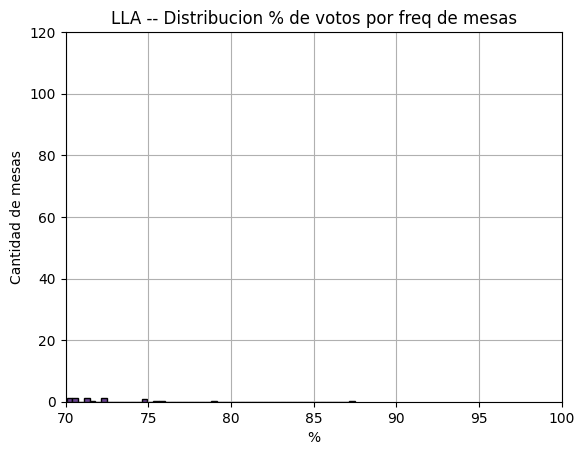

In [68]:
## LLA

# Estadisticas
lla_cola_mesas = len(lla_cola)
lla_cola_votos = lla_cola["votos_cantidad"].sum()
lla_cola_porc_sus_votos = (lla_cola["votos_cantidad"].sum() / lla_total["votos_cantidad"].sum()) * 100
lla_cola_porc_total = (lla_cola["votos_cantidad"].sum() / overall_total) * 100
print(f"LLA obtuvo 70% o mas en {lla_cola_mesas:,} mesas, por un total de {lla_cola_votos:,} votos.")
print(f"Esto representa el {lla_cola_porc_sus_votos:.2f}% de sus votos y el {lla_cola_porc_total:.2f}% del total de votos.\n")
# Cantidad de mesas por rango de porcentajes
lla_mesas, lla_bin_edges = np.histogram(lla_cola['votos_porcentaje'], bins=50, range=(70, 100))
print(f"LLA Mesas por Rangos")
for i in range(len(lla_mesas)):
    print(f"Del {lla_bin_edges[i]:.2f} al {lla_bin_edges[i+1]:.2f}: {lla_mesas[i]}")

# Crear Histograma
lla_cola['votos_porcentaje'].hist(bins=50, weights=lla_cola['ponderacion'], edgecolor='black', color="#694291")

# Add title and labels
plt.title('LLA -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 120)
plt.xlim(70, 100)

# Exportar imagen
plt.savefig('lla-cola.png')

# Mostrar grafico
plt.show()

JxC obtuvo 70% o mas en 77 mesas, por un total de 12,938 votos.
Esto representa el 0.21% de sus votos y el 0.05% del total de votos.

JxC Mesas por Rangos
Del 70.00 al 70.60: 13
Del 70.60 al 71.20: 18
Del 71.20 al 71.80: 12
Del 71.80 al 72.40: 4
Del 72.40 al 73.00: 8
Del 73.00 al 73.60: 5
Del 73.60 al 74.20: 2
Del 74.20 al 74.80: 2
Del 74.80 al 75.40: 3
Del 75.40 al 76.00: 1
Del 76.00 al 76.60: 2
Del 76.60 al 77.20: 2
Del 77.20 al 77.80: 0
Del 77.80 al 78.40: 1
Del 78.40 al 79.00: 0
Del 79.00 al 79.60: 1
Del 79.60 al 80.20: 0
Del 80.20 al 80.80: 0
Del 80.80 al 81.40: 0
Del 81.40 al 82.00: 0
Del 82.00 al 82.60: 0
Del 82.60 al 83.20: 0
Del 83.20 al 83.80: 0
Del 83.80 al 84.40: 0
Del 84.40 al 85.00: 0
Del 85.00 al 85.60: 0
Del 85.60 al 86.20: 0
Del 86.20 al 86.80: 0
Del 86.80 al 87.40: 0
Del 87.40 al 88.00: 0
Del 88.00 al 88.60: 0
Del 88.60 al 89.20: 0
Del 89.20 al 89.80: 0
Del 89.80 al 90.40: 0
Del 90.40 al 91.00: 0
Del 91.00 al 91.60: 0
Del 91.60 al 92.20: 0
Del 92.20 al 92.80: 1
Del 92

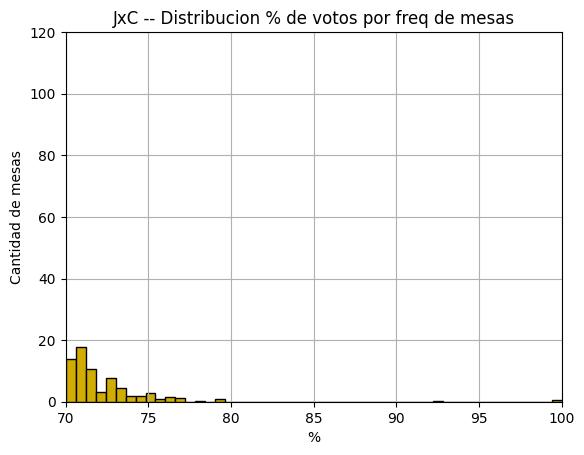

In [69]:
## JxC

# Estadisticas
jxc_cola_mesas = len(jxc_cola)
jxc_cola_votos = jxc_cola["votos_cantidad"].sum()
jxc_cola_porc_sus_votos = (jxc_cola["votos_cantidad"].sum() / jxc_total["votos_cantidad"].sum()) * 100
jxc_cola_porc_total = (jxc_cola["votos_cantidad"].sum() / overall_total) * 100
print(f"JxC obtuvo 70% o mas en {jxc_cola_mesas:,} mesas, por un total de {jxc_cola_votos:,} votos.")
print(f"Esto representa el {jxc_cola_porc_sus_votos:.2f}% de sus votos y el {jxc_cola_porc_total:.2f}% del total de votos.\n")
# Cantidad de mesas por rango de porcentajes
jxc_mesas, jxc_bin_edges = np.histogram(jxc_cola['votos_porcentaje'], bins=50, range=(70, 100))
print(f"JxC Mesas por Rangos")
for i in range(len(jxc_mesas)):
    print(f"Del {jxc_bin_edges[i]:.2f} al {jxc_bin_edges[i+1]:.2f}: {jxc_mesas[i]}")


# Crear Histograma
jxc_cola['votos_porcentaje'].hist(bins=50, weights=jxc_cola['ponderacion'], edgecolor='black', color="#d1ac03")

# Add title and labels
plt.title('JxC -- Distribucion % de votos por freq de mesas')
plt.xlabel('%')
plt.ylabel('Cantidad de mesas')
plt.ylim(0, 120)
plt.xlim(70, 100)

# Exportar imagen
plt.savefig('jxc-cola.png')

# Mostrar grafico
plt.show()

<h2>Analisis demografico para las anomalas de UP</h2>

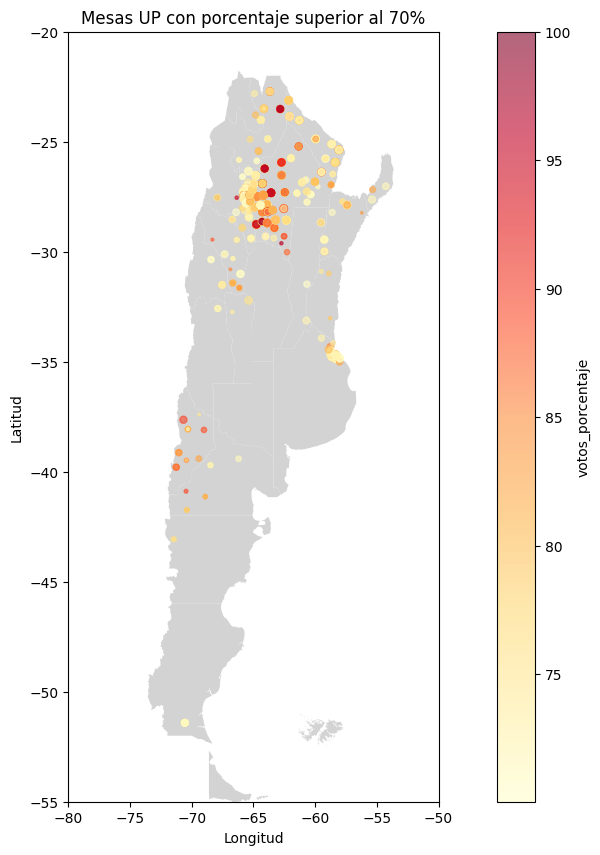

In [181]:
## Mapa Argentina - calor
up_cola_geo = pd.merge(
    up_cola,
    departamentos_data[['nombre', 'provincia_nombre', 'centroide_lat', 'centroide_lon']],
    left_on=['seccion_nombre', 'distrito_nombre'],
    right_on=['nombre', 'provincia_nombre'],
    how='left'  # Change to 'inner' if you only want rows with matches in both DataFrames
)

# Importar el shapefile
# Fuente: https://datos.gob.ar/dataset/jgm-servicio-normalizacion-datos-geograficos/archivo/jgm_8.26
# Es necesario agregar todos los archivos del ZIP a la carpeta "shapefiles"
argentina_map = gpd.read_file('shapefiles/provincias.shp')

# Crear grafico base
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Dibujar el mapa
argentina_map.plot(ax=ax, color='lightgrey')

dot_sizes = up_cola_geo['total_votos_mesa'] /10

# Dibujar los puntos de DF
up_cola_geo.plot(kind='scatter', x='centroide_lon', y='centroide_lat', 
            c='votos_porcentaje', s=dot_sizes, cmap='YlOrRd',  # Color map can be changed
            colorbar=True, alpha=0.6, ax=ax)

# Establecer limiter para la lat y long
ax.set_xlim(-80, -50)
ax.set_ylim(-55, -20)

# Etiquetas
ax.set_title('Mesas UP con porcentaje superior al 70%')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Exportar imagen
plt.savefig('up-cola-geo.png')

# Mostrar grafico
plt.show()

In [199]:
## Infor por provincia
# Agrupar los votos por provincia
# TODO: AGREGAR RANGOS A LAS MESAS (70-80 80-90 90-100)

up_geo_provincias = up_cola_geo.groupby('distrito_nombre').agg({
    'votos_cantidad': 'sum',
    'total_votos_mesa': 'sum',
    'id_mesa_unico':'size'
}).reset_index()

# Renombrar id_mesa_unico
up_geo_provincias = up_geo_provincias.rename(columns={'id_mesa_unico': 'mesas'})

# Calcular los porcentajes en el agregado
up_geo_provincias['porcentaje'] = (up_geo_provincias['votos_cantidad'] / up_geo_provincias['total_votos_mesa']) * 100


In [200]:
up_geo_provincias

,distrito_nombre,votos_cantidad,total_votos_mesa,mesas,porcentaje
0,Buenos Aires,29096,39775,153,73.15
1,Catamarca,3507,4645,28,75.50
2,Chaco,13327,17234,85,77.33
3,Chubut,144,189,2,76.19
4,Corrientes,3306,4429,22,74.64
5,Entre Ríos,176,227,3,77.53
6,Formosa,27398,35762,160,76.61
7,Jujuy,666,892,4,74.66
8,La Rioja,2623,3394,30,77.28
9,Mendoza,271,373,2,72.65


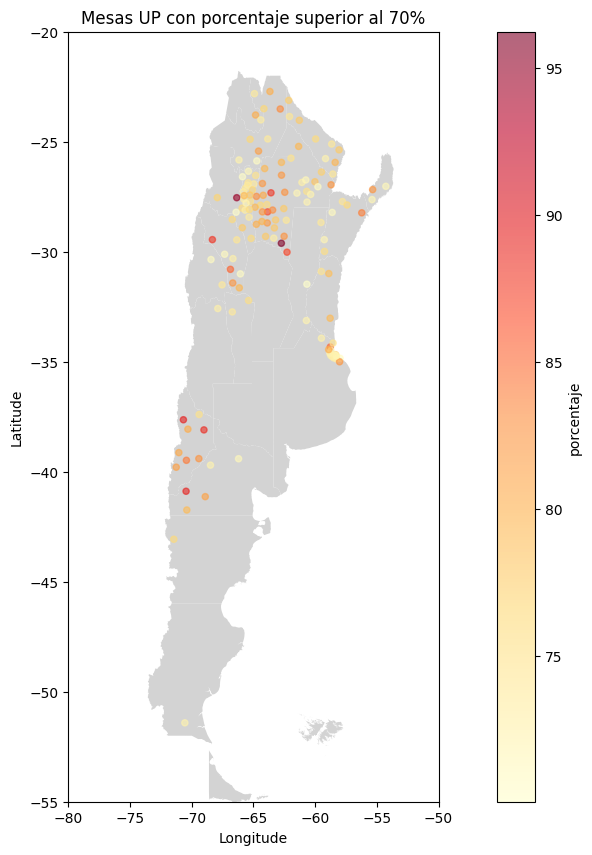

In [162]:
# Importar el shapefile
# Fuente: https://datos.gob.ar/dataset/jgm-servicio-normalizacion-datos-geograficos/archivo/jgm_8.26
# Es necesario agregar todos los archivos del ZIP a la carpeta "shapefiles"
argentina_map = gpd.read_file('shapefiles/provincias.shp')

# Create a basic plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the map
argentina_map.plot(ax=ax, color='lightgrey')

# Plot the points from your DataFrame
up_geo.plot(kind='scatter', x='centroide_lon', y='centroide_lat', 
            c='porcentaje', cmap='YlOrRd',  # Color map can be changed
            colorbar=True, alpha=0.6, ax=ax)

# Set the limits for latitude and longitude
ax.set_xlim(-80, -50)
ax.set_ylim(-55, -20)

# Set labels and title if you want
ax.set_title('Mesas UP con porcentaje superior al 70%')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Exportar imagen
plt.savefig('up-cola-geo.png')

# Show plot
plt.show()